In [58]:
import json
import os

import pandas as pd
from matplotlib import pyplot as plt

Reading the raw dataset.

In [59]:
DATASET_DIRECTORY = "../raw/article_bias_prediction"
data = []
for filename in os.listdir(DATASET_DIRECTORY):
    filepath = os.path.join(DATASET_DIRECTORY, filename)
    with open(filepath, "r") as file:
        data.append(json.load(file))

df = pd.DataFrame(data)
df

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,foreign_policy,Foreign Policy,1,https://foreignpolicy.com/2020/07/08/russia-in...,Why India and Russia Are Going to Stay Friends,2020-07-08,"Emily Tamkin, Robbie Gramer, Darcy Palder, Jus...","In December 1971 , India and Pakistan fought f...","In December 1971, India and Pakistan fought fo...",www.foreignpolicy.com,center,DiZK3jCOBd9zyThS
1,republican_party,CNN (Web News),0,http://politicalticker.blogs.cnn.com/2013/10/2...,Cruz to CNN: ‘I don’t work for the party bosse...,2013-10-20,,( CNN ) - Back in his home state after the reo...,6 years ago\n\n(CNN) - Back in his home state ...,www.politicalticker.blogs.cnn.com,left,6VcntpPK8ZAZABEl
2,fbi,The Hill,1,https://thehill.com/homenews/senate/474170-hor...,Horowitz offers troubling picture of FBI's Tru...,2019-12-11,,Department of Justice Inspector General Michae...,Department of Justice Inspector General Michae...,www.thehill.com,center,m4fCkEGKsTYXzVtc
3,epa,Washington Times,2,http://www.washingtontimes.com/news/2013/jun/2...,Newly released emails show EPA director's exte...,2013-06-02,Stephen Dinan,"Richard Windsor never existed at the EPA , but...","Richard Windsor never existed at the EPA, but ...",www.washingtontimes.com,right,ocb9Pwn70st4hH2h
4,elections,CNN (Web News),0,http://politicalticker.blogs.cnn.com/2012/09/2...,Some Romney backers still frustrated with stat...,2012-09-21,,Washington ( CNN ) - Some financial backers of...,7 years ago\n\nWashington (CNN) - Some financi...,www.politicalticker.blogs.cnn.com,left,9bcxLaeRtkaztETJ
...,...,...,...,...,...,...,...,...,...,...,...,...
37549,foreign_policy,CNN (Web News),0,http://www.cnn.com/2017/04/07/politics/un-secu...,Haley to UN: US 'prepared to do more' in Syria,2017-04-07,"Richard Roth, Kristina Sgueglia",( CNN ) US Ambassador to the United Nations Ni...,(CNN) US Ambassador to the United Nations Nikk...,www.cnn.com,left,44MQqr7YozfYMHbc
37550,religion_and_faith,Washington Times,2,http://www.washingtontimes.com/news/2013/may/1...,MANESS: Denying American soldiers the faith of...,2013-05-14,Rob Maness,As a former military commander both at home an...,ANALYSIS/OPINION:\n\nAs a former military comm...,www.washingtontimes.com,right,7kQk57ZOcRcD4L2L
37551,gun_control_and_gun_rights,Washington Times,2,http://www.washingtontimes.com/news/2013/apr/1...,Toomey: Open question whether background-check...,2013-04-14,David Sherfinski,Lawmakers on both sides of a proposal to expan...,Lawmakers on both sides of a proposal to expan...,www.washingtontimes.com,right,NTYlHyPZvcdlI7Ha
37552,elections,Politico,0,http://www.politico.com/story/2016/07/republic...,GOP operatives dread Trump convention,2016-07-12,"Alex Isenstadt, Kyle Cheney, Doug Palmer, Matt...","Each presidential election year , Republicans ...","Each presidential election year, Republicans e...",www.politico.com,left,zofbhJuOEkQDyfTX


Dropping useless columns. The content column is
> the processed and tokenized content, which is used as input to the different models

and so the original content can be dropped.

In [60]:
df = df.drop(columns=["topic", "bias", "source", "url", "date", "authors", "content_original", "source_url", "ID"])

Renaming and reordering columns.

In [61]:
df = df.rename(columns={"content": "body", "bias_text": "leaning"})
df = df[["title", "body", "leaning"]].copy()

Categorizing the leaning column.

In [62]:
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [80]:
df = df.dropna(subset=["body", "leaning"])

Printing duplicates.

In [63]:
df[df["body"].duplicated(keep=False)]

,title,body,leaning


Dropping the duplicates.

In [64]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [65]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,title,body,leaning,body_length,body_word_count
6903,Reports: US Airstrike Kills 3 Top ISIS Militants,Do You Approve of Obama 's Handling of Foreign...,right,131,26
27100,Obama Irate as Senate Votes Down Background Ch...,Do You Support Background Checks on Gun Buyers...,right,137,26
30085,Obama's IRS Moves to Close Down Political Spee...,Do You Approve Or Disapprove of President Obam...,right,185,34
19244,Obama Defends Immigration Delay: The Politics ...,President Barack Obama on Saturday blamed the ...,right,204,36
32716,Presidential Double Take: The Difference Four ...,Presidential Double Take : The Difference Four...,center,309,63


After inspection, articles with bodies shorter than 40 words seem to contain no political value. Removing them.

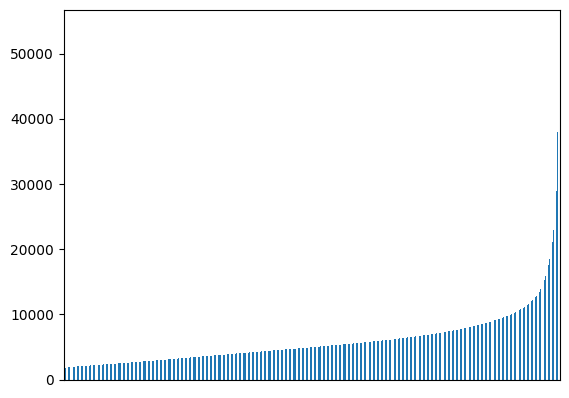

In [66]:
body_word_count_lower_bound = 40
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::100], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [67]:
df["body_length"].mean()

np.float64(5848.397443408789)

The leaning distribution.

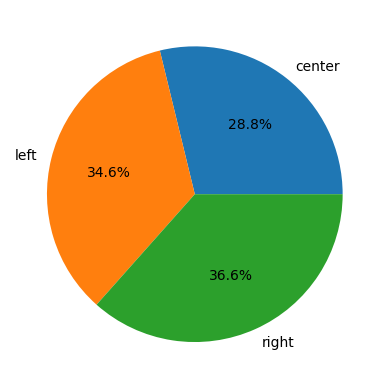

In [68]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

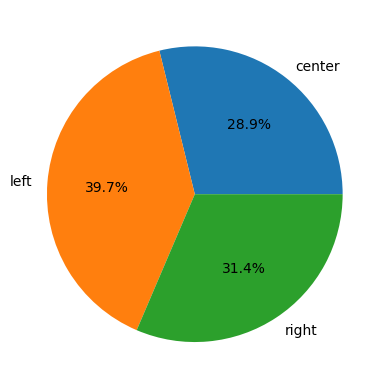

In [69]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

10815
13730
13005


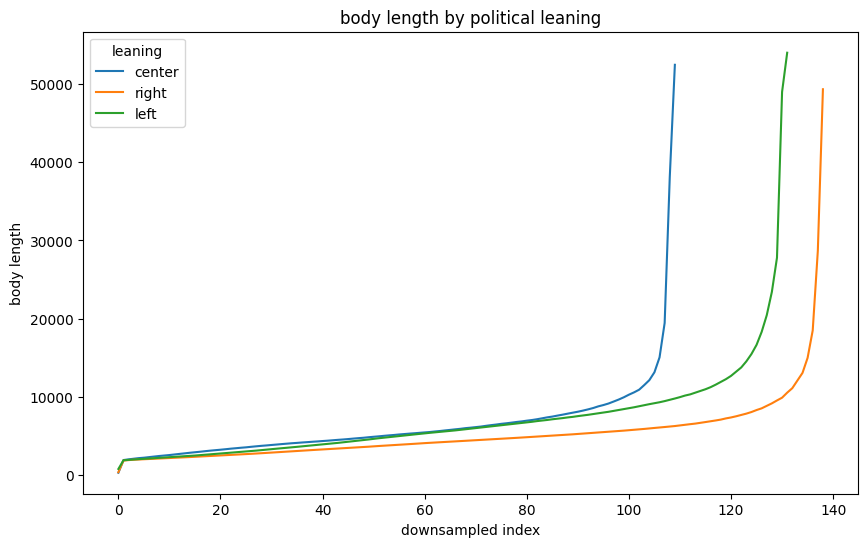

In [73]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [71]:
df.to_parquet("../preprocessed/article_bias_prediction.parquet")